In [45]:
#OLAP Thursday work
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import sqlite3
import seaborn as sns

In [46]:
#step 1: connect to db
def create_connection(db_file="kcc.db"):
    conn= sqlite3.connect(db_file)
    return conn

In [47]:
#step 2: put data in db
customers = pd.DataFrame({
    'customer_id': [1, 2, 3,4,5],
    'customer_name': ['Alice', 'Bob', 'Charlie','David','Eva'],
    'phone_no' : [888888888, 877777777, 866666666,855555555,844444444],
    'city' : ['New York', 'Los Angeles', 'Chicago','Houston','Phoenix'],
    'state' : ['NY', 'CA', 'IL','TX','AZ'],
})
orders = pd.DataFrame({
    'order_id': [101, 102, 103,104,105,106,107,108,109,110,111,112,113,114,115],
    'customer_id': [1, 5, 3, 2, 4, 5, 2, 4, 1, 3, 5, 4, 1, 5, 2],
    'order_date': pd.to_datetime(['2023-05-15', '2023-02-17', '2023-03-20','2023-04-15', '2023-01-17', '2023-02-20','2023-03-15', '2023-03-17', '2023-04-20','2023-05-15', '2023-02-17', '2023-03-20','2023-05-15', '2023-01-17', '2023-05-20']),
    'order_amount': [250.00, 450.50, 300.75, 150.00, 500.00, 700.25, 200.00, 400.00, 350.00, 600.00, 800.00, 900.00, 1000.00, 1100.00, 1200.00],
    'cookie_type': ['Chocolate Chip', 'Gingerbread', 'Lemon','Peanut Butter', 'Snickerdoodle', 'Chocolate Chip','Lemon', 'Gingerbread', 'Gingerbread','Lemon', 'Gingerbread', 'Peanut Butter','Peanut Butter', 'Chocolate Chip', 'Gingerbread'],})
shipment = pd.DataFrame({
    'shipment_id': [201, 202, 203,204,205,206,207,208,209,210,211,212,213,214,215],
    'order_id': [101, 102, 103,104,105,106,107,108,109,110,111,112,113,114,115],
    'shipment_date': pd.to_datetime(['2023-01-16', '2023-01-18', '2023-01-21','2023-02-16', '2023-02-18', '2023-02-21','2023-03-16', '2023-03-18', '2023-03-21','2023-04-16', '2023-04-18', '2023-04-21','2023-05-16', '2023-05-18', '2023-05-21']),
    'delivery_date': pd.to_datetime(['2023-01-20', '2023-01-22', '2023-01-25','2023-02-20', '2023-02-22', '2023-02-25','2023-03-20', '2023-03-22', '2023-03-25','2023-04-20', '2023-04-22', '2023-04-25','2023-05-20', '2023-05-22', '2023-05-25']),
    'shipping_method': ['Standard', 'Express', 'Standard','Express', 'Standard', 'Express','Standard', 'Express', 'Standard','Express', 'Standard', 'Express','Standard', 'Express', 'Standard'],
})

In [48]:
#Step 3: load to sqldb
conn= create_connection()
customers.to_sql('customers', conn, if_exists= 'replace', index= False)
orders.to_sql('orders', conn, if_exists= 'replace')
shipment.to_sql('shipment', conn, if_exists= 'replace', index= False)
print('Tables created')

Tables created


In [62]:
#step 4: OLAB operations
#sql sctipts
#script for total sales per month
query_total_sales_per_month = """
SELECT strftime('%Y-%m', order_date) as order_by_month, SUM(order_amount) AS total_sales
FROM orders
GROUP BY order_by_month
ORDER BY order_by_month;
"""
query_total_sales_per_month_df= pd.read_sql_query(query_total_sales_per_month, conn)
print("Total sales per month:")
display(query_total_sales_per_month_df)

#script for most shipped to states
query_most_shipped_to_states = """
Select state, COUNT(order_id) AS total_shipments
FROM customers
INNER JOIN orders ON customers.customer_id = orders.customer_id
GROUP BY state
ORDER BY total_shipments DESC
"""
query_most_shipped_to_states_df= pd.read_sql_query(query_most_shipped_to_states, conn)
print("Most shipped to states:")
display(query_most_shipped_to_states_df)

#script for months orders were placed by Alice and Bob
buying_months_alice_bob = """
SELECT customer_name, strftime('%Y-%m', order_date) AS order_month, COUNT(order_id) AS frequency
FROM customers
LEFT JOIN orders ON customers.customer_id=orders.customer_id
WHERE customer_name = 'Alice' OR customer_name= 'Bob'
GROUP BY Order_month, customer_name
ORDER BY frequency DESC
"""
buying_months_alice_bob_df = pd.read_sql_query(buying_months_alice_bob, conn)
print("Buying months for Alice and Bob:")
display(buying_months_alice_bob_df)

Total sales per month:


,order_by_month,total_sales
0,2023-01,1600.00
1,2023-02,1950.75
2,2023-03,1800.75
3,2023-04,500.00
4,2023-05,3050.00


Most shipped to states:


,state,total_shipments
0,AZ,4
1,TX,3
2,NY,3
3,CA,3
4,IL,2


Buying months for Alice and Bob:


,customer_name,order_month,frequency
0,Alice,2023-05,2
1,Bob,2023-03,1
2,Alice,2023-04,1
3,Bob,2023-04,1
4,Bob,2023-05,1


In [63]:
#Step 6:Pivot tables
#total sales per month
pivot_total_sales_per_month=pd.pivot_table( data=orders, index= orders['order_date'].dt.to_period('M'), columns= 'cookie_type', values='order_id', aggfunc='count')
print("Pivot Table - Total Sales Per Month by Cookie Type:")
display(pivot_total_sales_per_month)

Pivot Table - Total Sales Per Month by Cookie Type:


cookie_type,Chocolate Chip,Gingerbread,Lemon,Peanut Butter,Snickerdoodle
order_date,,,,,
2023-01,1.0,NaN,NaN,NaN,1.0
2023-02,1.0,2.0,NaN,NaN,NaN
2023-03,NaN,1.0,2.0,1.0,NaN
2023-04,NaN,1.0,NaN,1.0,NaN
2023-05,1.0,1.0,1.0,1.0,NaN


In [69]:
#Step 7:HOLAP operations
#get data to store in memory
shipment_df= pd.read_sql_query("SELECT COUNT(order_id) as monthly_orders, state FROM orders INNER JOIN customers ON orders.customer_id= customers.customer_id GROUP BY state ORDER BY monthly_orders", conn)
print("HOLAP - Monthly Orders by State:")
display(shipment_df)


HOLAP - Monthly Orders by State:


,monthly_orders,state
0,2,IL
1,3,CA
2,3,NY
3,3,TX
4,4,AZ


In [ ]:
#step 8: OLAP operations
# Slicing - filtering to a sinngle dimention
# Total shipments in the month of January
shipments_df= pd.read_sql_query( "SELECT COUNT(orders.order_id) as jan_shipments " 
                                "FROM orders INNER JOIN shipment ON orders.order_id= shipment.order_id "  
                                "WHERE strftime('%Y-%m',shipment_date)= '2023-01'", conn)
print("shipments in january")
display(shipments_df)

#dicing - filtering to multiple dimentions
# Total shipments in the month of January to California (CA)
shipments2_df= pd.read_sql_query("SELECT  COUNT(orders.order_id) as jan_shipments_CA " 
                                 "FROM orders INNER JOIN shipment ON orders.order_id= shipment.order_id " 
                                 "INNER JOIN customers ON orders.customer_id= customers.customer_id "  
                                 "WHERE strftime('%Y-%m',shipment_date)= '2023-01' AND state ='CA'", conn)
print("shipments in january to CA")
display(shipments2_df)

#rollup - aggregated data (seeing bigger picture)
sales_df=pd.read_sql_query("SELECT state, SUM(order_amount) as total_sales FROM orders INNER JOIN customers ON orders.customer_id= customers.customer_id GROUP BY state ORDER BY total_sales DESC", conn)
print("Rollup - Total Sales by State:")
display(sales_df)

#drilldown - detailed data (descending to more detailed level)
detailed_sales_df=pd.read_sql_query("SELECT state, city, SUM(order_amount) as total_sales FROM orders INNER JOIN customers ON orders.customer_id= customers.customer_id GROUP BY state, city ORDER BY state, city", conn)
print("Drilldown - Total Sales by State and City:")
display(detailed_sales_df)

shipments in january


,jan_shipments
0,3


shipments in january to CA


,jan_shipments_CA
0,0


Rollup - Total Sales by State:


,state,total_sales
0,AZ,3050.75
1,TX,1800.00
2,NY,1600.00
3,CA,1550.00
4,IL,900.75


Drilldown - Total Sales by State and City:


,state,city,total_sales
0,AZ,Phoenix,3050.75
1,CA,Los Angeles,1550.00
2,IL,Chicago,900.75
3,NY,New York,1600.00
4,TX,Houston,1800.00


C:\Users\HP\AppData\Local\Temp\ipykernel_14732\381246882.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=sales_df, x='state', y='total_sales', palette='viridis')


Text(0.5, 1.0, 'cookie sales per month')

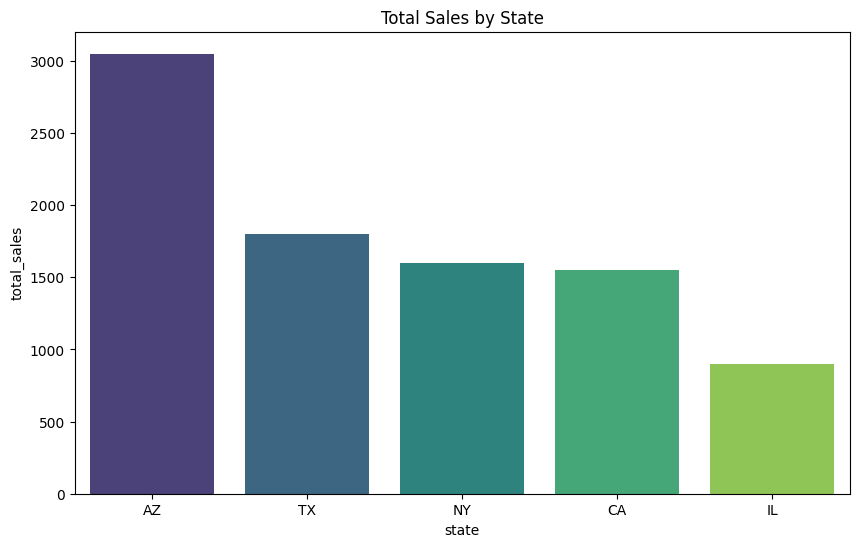

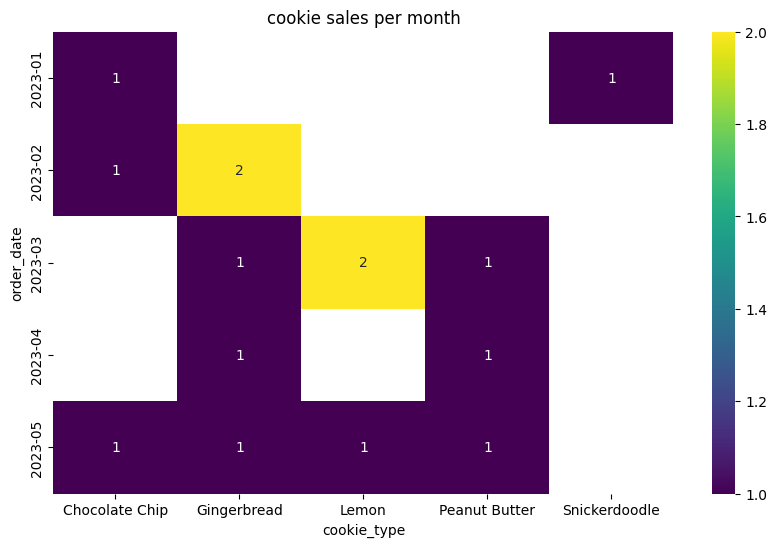

In [99]:
#step 5:visualisation
#revenue per state
plt.figure(figsize=(10,6))
sns.barplot(data=sales_df, x='state', y='total_sales', palette='viridis')
plt.title('Total Sales by State')
#heatmap of sales per month
plt.figure(figsize=(10,6))
sns.heatmap(pivot_total_sales_per_month, cmap='viridis', annot=True)
plt.title('cookie sales per month')